In [164]:
%matplotlib inline

import sys
sys.path.append("../")
import copy
import itertools
import operator

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA


import helpers
from src import dataset

In [165]:
excel_file = "20160921-analysisofestimatedarrivals.xlsx"
data = dataset.load_excel(excel_file)
data = dataset.load_all_regions(data)

In [166]:
df_italy = data["italy"] # Arrivals to Italy
df_greek_island = data["greek_island"] # Arrivals to Greek Island
df_mainland_greece = data["mainland_greece"] # Arrivals to Mainland greece
df_fyrom = data["fyrom"] # Arrivals to fYRoM
df_serbia = data["serbia"] # Arrivals to Serbia
df_croatia = data["croatia"] # Arrivals to Croatia
df_hungry = data["hungry"] # Arrivals to Hungry
df_slovenia = data["slovenia"] # Arrivals to Slovenia
df_austria = data["austria"] # Arrivals to Austria

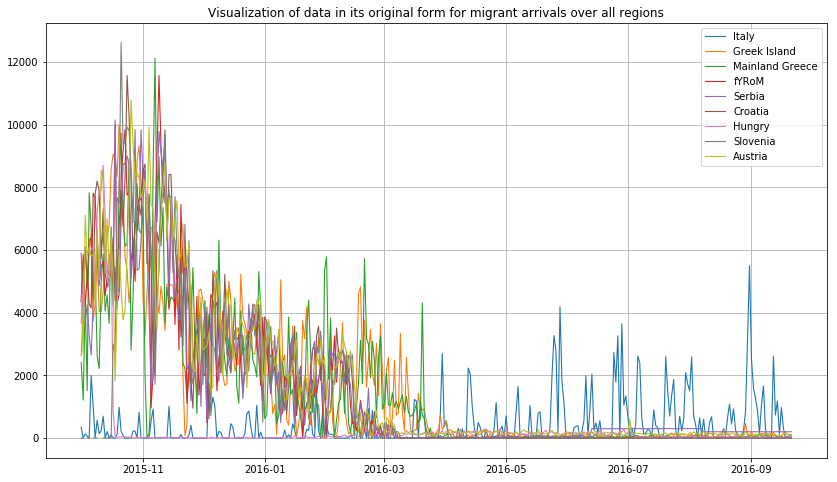

In [167]:
plt.figure(figsize=(14,8))
plt.plot(df_italy.index, df_italy.iloc[:, 0], label="Italy", linewidth=1.1)
plt.plot(df_greek_island.index, df_greek_island.iloc[:, 0], label="Greek Island", linewidth=1.1)
plt.plot(df_mainland_greece.index, df_mainland_greece.iloc[:, 0], label="Mainland Greece", linewidth=1.1)
plt.plot(df_fyrom.index, df_fyrom.iloc[:, 0], label="fYRoM", linewidth=1.1)
plt.plot(df_serbia.index, df_serbia.iloc[:, 0], label="Serbia", linewidth=1.1)
plt.plot(df_croatia.index, df_croatia.iloc[:, 0], label="Croatia", linewidth=1.1)
plt.plot(df_hungry.index, df_hungry.iloc[:, 0], label="Hungry", linewidth=1.1)
plt.plot(df_slovenia.index, df_slovenia.iloc[:, 0], label="Slovenia", linewidth=1.1)
plt.plot(df_austria.index, df_austria.iloc[:, 0], label="Austria", linewidth=1.1)
plt.legend(loc="best")
plt.title("Visualization of data in its original form for migrant arrivals over all regions")
plt.grid(True)
plt.show()

In [168]:
df = df_italy # Seriies to test
column_name = df.columns[0]
print("Region %s will be used for the analysis" % column_name)

Region Arrivals to Italy will be used for the analysis


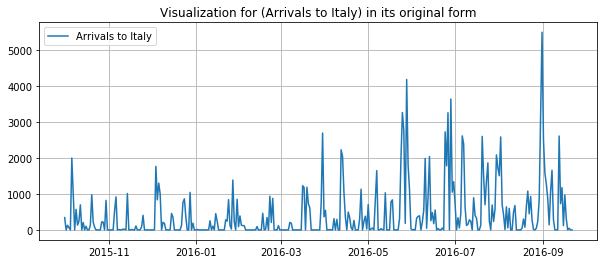

In [169]:
plt.figure(figsize=(10,4))
plt.plot(df, label=column_name)
plt.legend(loc="best")
plt.title("Visualization for (%s) in its original form" %df.columns[0])
plt.grid()
plt.show()

In [170]:
#Stationarity test
def test_stationarity(timeseries, win_size=30):
    #Find rolling statistics
    rolmean = timeseries.rolling(window=win_size).mean()
    rolstd = timeseries.rolling(window=win_size).std()

    #Plot rolling statistics:
    plt.figure(figsize=(10,8))
    orig = plt.plot(timeseries, linewidth=1.2,label='Original')
    mean = plt.plot(rolmean, linewidth=1.2, label='Rolling Mean')
    std = plt.plot(rolstd, linewidth=1.2, label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation for Stationarity (Window size %s days)' % win_size)
    plt.grid()
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries[timeseries.columns[0]], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

def show_seasonality(series, freq=7):
    plt.figure(figsize=(10,4))
    decomposition = seasonal_decompose(series, freq=freq, model="additive")
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='best')
    plt.tight_layout()
    return(trend, seasonal, residual)

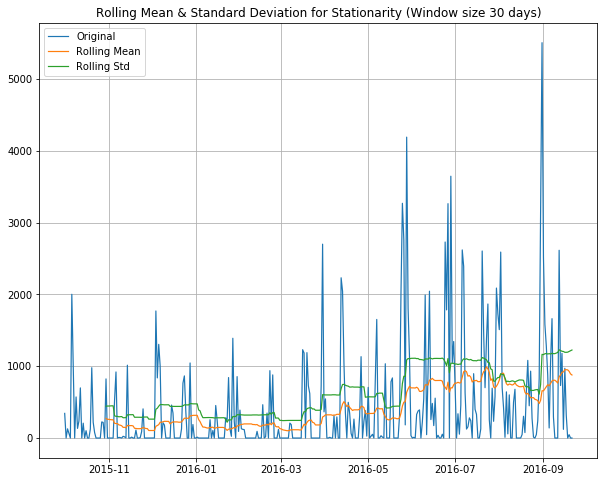

Results of Dickey-Fuller Test:
Test Statistic                -8.677227e+00
p-value                        4.382857e-14
#Lags Used                     1.000000e+00
Number of Observations Used    3.550000e+02
Critical Value (1%)           -3.448906e+00
Critical Value (5%)           -2.869716e+00
Critical Value (10%)          -2.571126e+00
dtype: float64


In [171]:
test_stationarity(df)

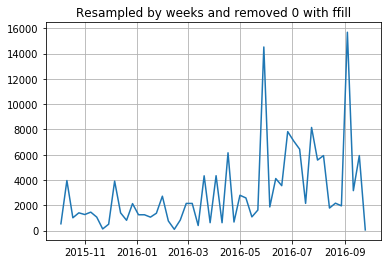

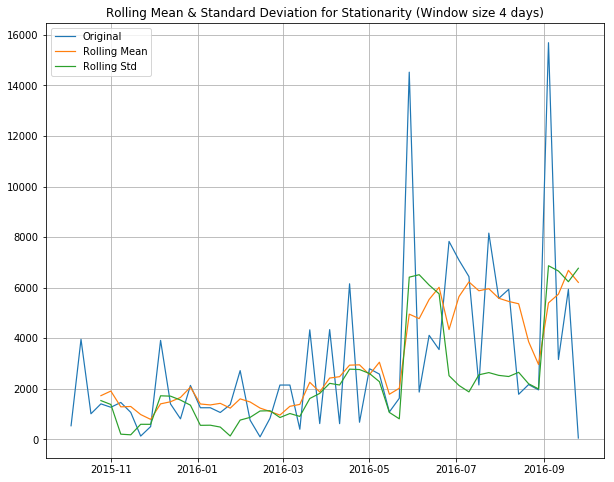

Results of Dickey-Fuller Test:
Test Statistic                 -0.414204
p-value                         0.907700
#Lags Used                      5.000000
Number of Observations Used    46.000000
Critical Value (1%)            -3.581258
Critical Value (5%)            -2.926785
Critical Value (10%)           -2.601541
dtype: float64


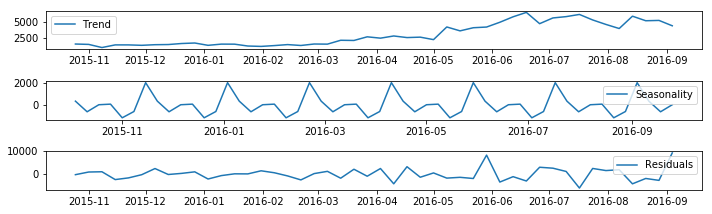

In [150]:
# Resample by weeks
w_df = df.resample("W").sum()
w_df = w_df.reset_index().rename(columns={'Date': 'ds', column_name: 'y'})
w_df = w_df.set_index("ds")
fill_method = "ffill"
w_df['y'] = w_df['y'].replace(to_replace=0, method=fill_method)

#Plot by weeks resample
plt.plot(w_df)
plt.title("Resampled by weeks and removed 0 with %s" % fill_method)
plt.grid()
plt.show()

#Test stationarity for weeks resample
test_stationarity(w_df, win_size=4)

# Show seasonality in weekly resampled time series
(trend, seasonality, resid) = show_seasonality(w_df)

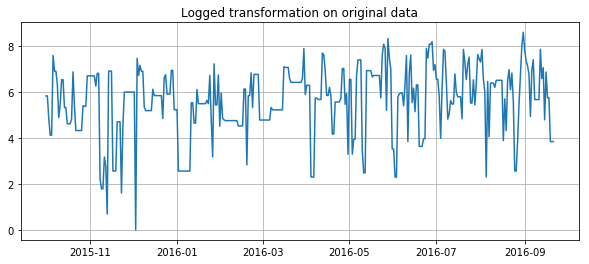

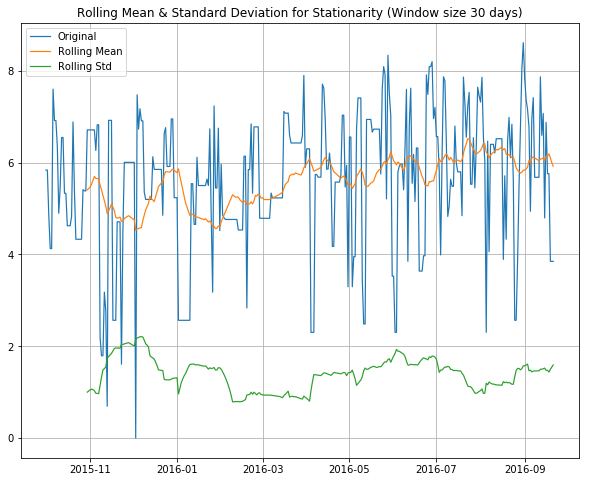

Results of Dickey-Fuller Test:
Test Statistic                -1.031730e+01
p-value                        3.073452e-18
#Lags Used                     0.000000e+00
Number of Observations Used    3.560000e+02
Critical Value (1%)           -3.448853e+00
Critical Value (5%)           -2.869693e+00
Critical Value (10%)          -2.571114e+00
dtype: float64


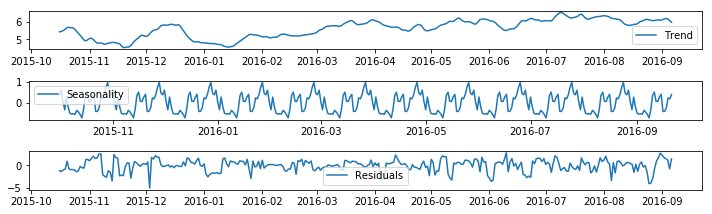

In [209]:
# Transformation to log on original data
l_df = copy.deepcopy(df)
l_df[l_df.columns[0]] = l_df[column_name].replace(to_replace=0, method=fill_method) # Replace 0 in series
l_df[l_df.columns[0]] = np.log(list(l_df[column_name].values))
## l_df[l_df.columns[0]] = np.log(l_df)


#Plot after taking log
plt.figure(figsize=(10,4))
plt.plot(l_df)
plt.title("Logged transformation on original data")
plt.grid()
plt.show()

#Stationarity test on log series
test_stationarity(l_df)

# Show seasonality in original logged time series
(trend, seasonality, resid) = show_seasonality(l_df, freq=30)

In [210]:
shifting = 3

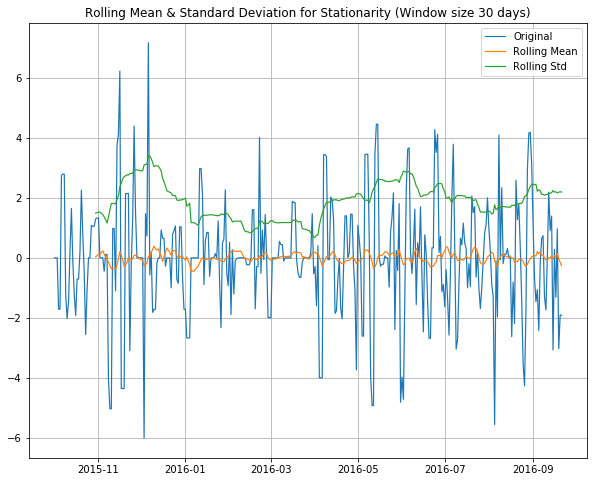

Results of Dickey-Fuller Test:
Test Statistic                -7.348762e+00
p-value                        1.019031e-10
#Lags Used                     1.700000e+01
Number of Observations Used    3.390000e+02
Critical Value (1%)           -3.449788e+00
Critical Value (5%)           -2.870104e+00
Critical Value (10%)          -2.571332e+00
dtype: float64


In [211]:
# Applying differencing with lag shift
l_df_diff = l_df - l_df.shift(shifting)
# l_df_diff.dropna(inplace=True)
l_df_diff.fillna(0, inplace=True)

# Stationarity test on log difference
test_stationarity(l_df_diff)

In [214]:
import warnings
warnings.filterwarnings("ignore")
def grid_search(series, search_range=None):
    """Find the best p, d and q values for time series.
    
    :param series: Time series
    :type series: DataFrame
    :param search_range: Maximum value range for p, d and q
    :type search_range: list
    :returns: tuple containing lowest aic and p,d and q combination
    """
    lowest = 100000
    lowest_combination = None
    if search_range is None:
        search_range = range(0, 5)
    p=d=q=search_range
    pdq=list(itertools.product(p, d, q))
    for combination in pdq:
        try:
            model = ARIMA(series, order=combination)
            arima_fit = model.fit()
            prediction = arima_fit.fittedvalues
            if len(series) > len(series):
                print(len(series), len(predictions))
                difference = len(series) - len(predictions)
                print("Length difference %s" % difference)
                series.drop(series.tail(difference).index,inplace=True)
            error = helpers.measure_rmse(series, prediction)
            print("Combination -> %s, error -> %s, aic -> %s" % (combination, error, arima_fit.aic))            
        except:
            continue
        if error <= lowest:
            lowest = error
            lowest_combination = combination
            aic = arima_fit.aic
    return (lowest_combination, lowest, aic)

In [215]:
df_to_test = copy.deepcopy(l_df_diff)
df_to_test.head()

,Arrivals to Italy
Date,
2015-10-01,0.000000
2015-10-02,0.000000
2015-10-03,0.000000
2015-10-04,-1.710596
2015-10-05,-1.710596


In [216]:
grid_search_results = grid_search(df_to_test)
best_combination = grid_search_results[0]
print("Final result is: best combination -> %s, error -> %s, aic -> %s" % grid_search_results)

Combination -> (0, 0, 0), error -> 1.9384291986323794, aic -> 1489.702971629568
Combination -> (0, 0, 1), error -> 1.809759900080114, aic -> 1442.760525145275
Combination -> (0, 0, 2), error -> 1.4364652932964916, aic -> 1280.915176819988
Combination -> (0, 0, 3), error -> 1.3672779438749865, aic -> 1246.9911664371068
Combination -> (0, 0, 4), error -> 1.3074117572794746, aic -> 1217.7973757183338
Combination -> (1, 0, 0), error -> 1.7851968640562799, aic -> 1433.0697665051391
Combination -> (1, 0, 1), error -> 1.7806468478697208, aic -> 1433.2541911080257
Combination -> (1, 0, 2), error -> 1.3890728336415765, aic -> 1258.3475855149145
Combination -> (1, 0, 3), error -> 1.259302996042281, aic -> 1190.490115599571
Combination -> (1, 0, 4), error -> 1.2592286819720016, aic -> 1192.3993320251843
Combination -> (2, 0, 0), error -> 1.7695810009315693, aic -> 1428.8314659503567
Combination -> (2, 0, 1), error -> 1.6067806728078236, aic -> 1362.3222303094599
Combination -> (2, 0, 2), error ->

Text(0.5, 1.0, 'Plot on series transformation fit, with Root mean squared error: 1.2539012767409654')

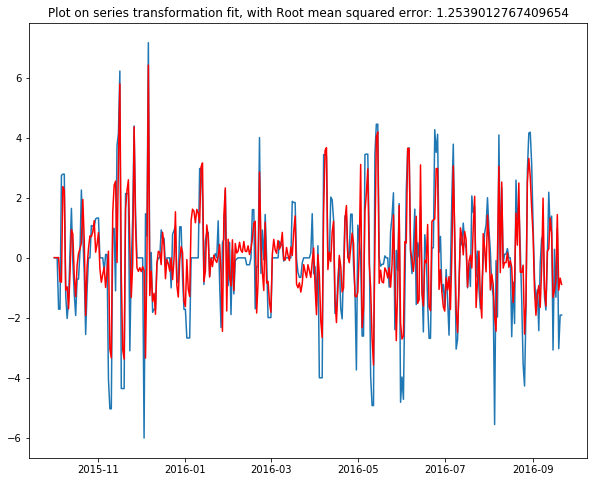

In [217]:
model = ARIMA(df_to_test, order=best_combination)
results_ARIMA = model.fit()

plt.figure(figsize=(10,8))
plt.plot(df_to_test)
plt.plot(results_ARIMA.fittedvalues, color="red")
error = helpers.measure_rmse(df_to_test, results_ARIMA.fittedvalues)
plt.title("Plot on series transformation fit, with Root mean squared error: %s" % error)

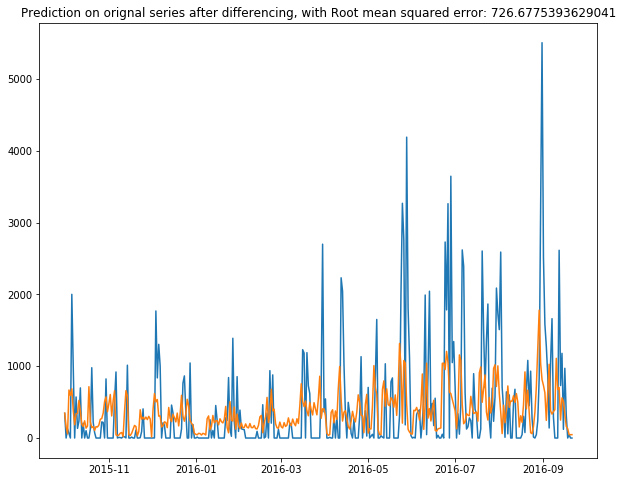

In [225]:
predictions = pd.Series(results_ARIMA.fittedvalues, copy=True).shift(-shifting)
predictions_cumsum = predictions.cumsum()
predictions_log = pd.Series(l_df[column_name], index=l_df.index)
predictions_log = predictions_log.add(predictions, fill_value=0)
predictions_arima = np.exp(predictions_log)
plt.figure(figsize=(10,8))
plt.plot(df)
plt.plot(predictions_arima)
error = helpers.measure_rmse(df, predictions_arima)
plt.title("Prediction on orignal series after differencing, with Root mean squared error: %s" % error)
plt.show()

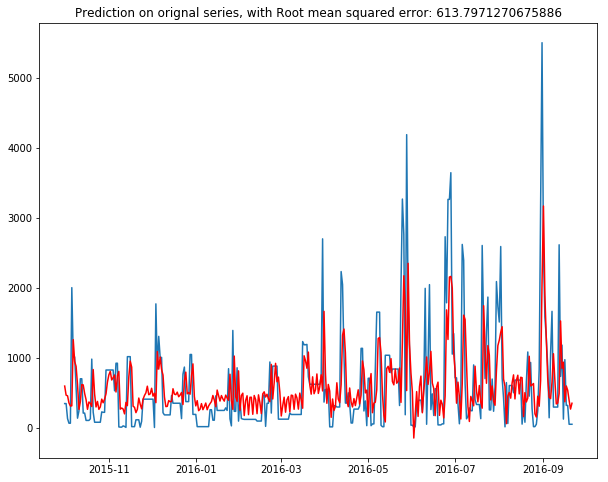

In [226]:
orig_df = copy.deepcopy(df)
orig_df[column_name] = orig_df[column_name].replace(to_replace=0, method=fill_method)
orig_df = orig_df.fillna(method=fill_method)

model = ARIMA(orig_df, order=best_combination)
results_ARIMA = model.fit()

plt.figure(figsize=(10,8))
plt.plot(orig_df)
plt.plot(results_ARIMA.fittedvalues, color="red")
error = helpers.measure_rmse(orig_df, results_ARIMA.fittedvalues)
plt.title("Prediction on orignal series, with Root mean squared error: %s" % error)
plt.show()

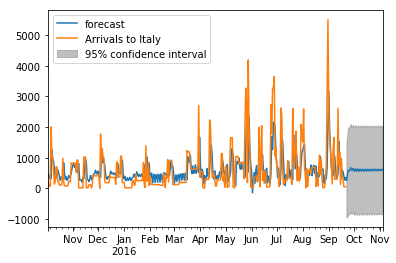

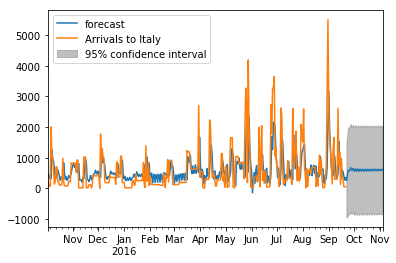

In [231]:
results_ARIMA.plot_predict(1, 400)